In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold,GroupKFold,KFold,TimeSeriesSplit,GridSearchCV,train_test_split
from rfpimp import *
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import f1_score,roc_auc_score,mean_squared_error
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,StandardScaler
from tqdm import tqdm
from datetime import date
from collections import Counter, defaultdict
import random

pd.set_option('max.rows',8000)
pd.set_option('max.columns',30)

sns.set(rc={'figure.figsize':(13,10)})

# TO RUN THIS NOTEBOOK

1) Download the pacakages below with their respective versions.

2) This code was run on MACBOOK PRO M1 16GB RAM, on the via Rosetta.

3) The transaction file should be in the same folder as the notebook.

In [57]:
#Source https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
!python --version

pandas==1.2.0
numpy==1.21.2
sklearn==1.0.1
lightgbm==3.2.1
seaborn==0.11.1
Python 3.8.12


# DATA LOADING AND STRUCTURE OF DATA

The data provided is a json file, which is loaded directly using pandas package.
The JSON has 786363 records and 29 fields.

In [58]:
df = pd.read_json('transactions.txt',lines=True)

In [59]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [60]:
print(f'\nShape of dataframe is : \n{df.shape}\n')
print(f'\nSum of Null values in dataframe are : \n{df.isnull().sum()}\n')
print(f'\nUnique values of each column : \n{df.nunique()}\n')
print(f'\nDatatypes values of each column : \n{df.dtypes}\n')


Shape of dataframe is : 
(786363, 29)


Sum of Null values in dataframe are : 
accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64


Unique values of each column : 
acc

In [61]:
print(f'Some statistics are \n{df.describe()}')

Some statistics are 
       accountNumber    customerId    creditLimit  availableMoney  \
count   7.863630e+05  7.863630e+05  786363.000000   786363.000000   
mean    5.372326e+08  5.372326e+08   10759.464459     6250.725369   
std     2.554211e+08  2.554211e+08   11636.174890     8880.783989   
min     1.000881e+08  1.000881e+08     250.000000    -1005.630000   
25%     3.301333e+08  3.301333e+08    5000.000000     1077.420000   
50%     5.074561e+08  5.074561e+08    7500.000000     3184.860000   
75%     7.676200e+08  7.676200e+08   15000.000000     7500.000000   
max     9.993896e+08  9.993896e+08   50000.000000    50000.000000   

       transactionAmount        cardCVV     enteredCVV  cardLast4Digits  \
count      786363.000000  786363.000000  786363.000000    786363.000000   
mean          136.985791     544.467338     544.183857      4757.417799   
std           147.725569     261.524220     261.551254      2996.583810   
min             0.000000     100.000000       0.000000   

# Some Preprocessing

So we will do some preprocessing such coverting date values to date type, removing columns with only single 
value etc.

In [62]:
#Removing Columns with single unique value

for i in list(df.columns):
    if df[i].nunique() == 1:
        df.drop(i,inplace=True,axis=1)

# Converting some columns from bool to int

col_dtype_int = []
col_dtype_obj = []
for i in df.columns:
    if df[i].dtype == 'int64' or df[i].dtype=='float64':
        col_dtype_int.append(i)
    elif df[i].dtype == 'object':
        col_dtype_obj.append(i)
    else:
        df[i] = df[i].astype('int')
        col_dtype_int.append(i)

#Converting some dates to datetime and also creating some date-time features such as hr,day etc .

days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['Date_trans'] = df['transactionDateTime'].apply(lambda x: x.date())
df['Date_trans'] = pd.to_datetime(df['Date_trans'])
df['transaction_day'] = df['Date_trans'].apply(lambda x: x.day)
df['transaction_month'] = df['Date_trans'].apply(lambda x: x.month)
df['trans_day_of_week'] = df['Date_trans'].dt.dayofweek
df['trans_day_of_week'] = df['trans_day_of_week'].apply(lambda x: days[x])
df['trans_hr'] = df['transactionDateTime'].apply(lambda x: x.hour)
df['trans_minute'] = df['transactionDateTime'].apply(lambda x: x.minute)

In [63]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date_trans,transaction_day,transaction_month,trans_day_of_week,trans_hr,trans_minute
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,2016-08-13,13,8,Sat,14,27
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,2016-10-11,11,10,Tues,5,5
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,2016-11-08,8,11,Tues,9,18
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,2016-12-10,10,12,Sat,2,14
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,2016-03-24,24,3,Thurs,21,4


In [64]:
display(df.columns)
print(f"The total number of columns after creating some features are: {len(df.columns)}")

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'Date_trans', 'transaction_day',
       'transaction_month', 'trans_day_of_week', 'trans_hr', 'trans_minute'],
      dtype='object')

The total number of columns after creating some features are: 29


# ANALYSIS AND SOME INSIGHTS

1) There seems to be negative values in the available balance column,which means people's balances can go negative,when they spend more money then their credit limit.

2) CurrentBalance and available balance update monthly so if a customer makes multiple transactions in a single month his current balance will add up with the transaction amounts and the available balance will reduce.

3) CurrentBalance resets to 0 at the start of billing-cycle every month and availble balance resets to credit limit 
similarly.

4) Looking at the distribution of variable of interest it seems that the data is highly imbalanced, with 98.42% of the values belonging to class 0 i.e Non Fraud and rest to Fraud.

<AxesSubplot:xlabel='isFraud', ylabel='count'>

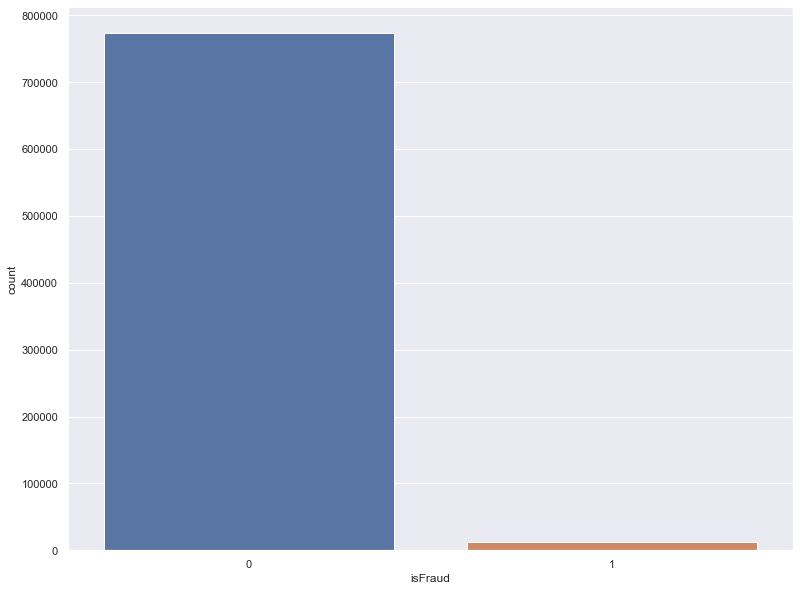

In [65]:
sns.countplot(x='isFraud',data=df)

In [66]:
df['isFraud'].value_counts(normalize= True)

0    0.98421
1    0.01579
Name: isFraud, dtype: float64

<b>Lets look at other variables such as transactionAmount its distribution, the variable transaction type and also lets check what these columns entail.</b>

<AxesSubplot:xlabel='transactionAmount', ylabel='Count'>

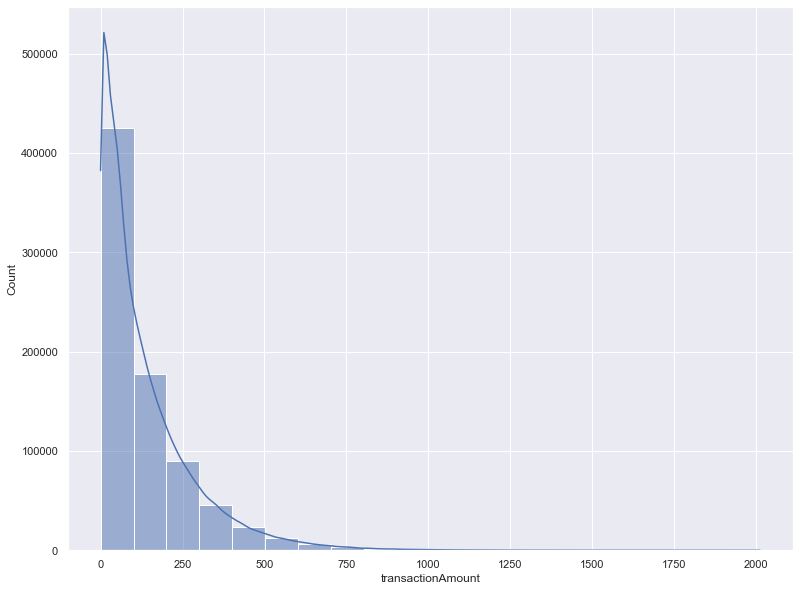

In [67]:
sns.histplot(data=df,x = 'transactionAmount',bins=20,kde=True)

The data seems skewed to the right in the above figure, i.e the mean of transaction amounts is greater than the median.Looking at the graph it there are some outliers in the transactionAmount column.

# Some Analysis of the variable Transaction Type

1) Transaction type has 4 categories Purchase, Address verification, Reversal and a blank category too , below there is a histogram of count of these values and their value_counts too.

2) From the analysis of these we can find out how many transactions have been <b>REVERSALS</b> i.e <b>20303 records</b>.

3) We can also conclude from the analysis below that most of the blank category can be renamed as "PURCHASE" too.

4) When in transactiontype column if the category is "address verification" a fee of 0 dollars is deducted.

5) There are some instances of cashiers accidently double swipes a card or a transaction also called <b>multi swipe spending</b> , these all belong mostly to 'Category of transaction type PURCHASE' ie total records being <b>7402</b>.    .

<AxesSubplot:xlabel='transactionType', ylabel='count'>

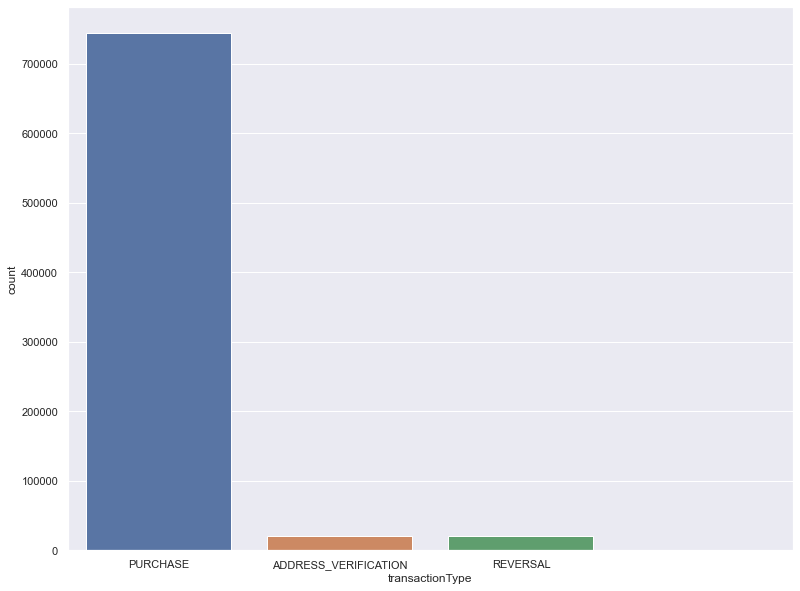

In [68]:
#Count of all the transaction Types

sns.countplot(x='transactionType',data=df)

In [69]:
#number of transactions that were reversals

df['transactionType'].value_counts()

#Total Amount in dollars of reversed transaction
print(f"The total amount of reversed transaction in $:\
      {df[df['transactionType'] == 'REVERSAL']['transactionAmount'].sum()}")

The total amount of reversed transaction in $:      2821792.5


In [70]:
"""
The way i find a multiswipe transaction is, i m checking all the transactions ,transactiontype made on a unique date
by a single accountNumber and customerID. Also customerID and accountNumber seem to be the same for every unique
user.

"""
temp = df.groupby(['accountNumber','customerId','Date_trans','transactionAmount','transactionType','merchantName']).agg({'Date_trans':['count']})
temp.columns = [''.join(x) for x in temp.columns]
temp.rename(columns={
    'Date_transcount':'not_multiswipe'
},inplace=True)
df = pd.merge(df,temp,on=['accountNumber','customerId','Date_trans','transactionAmount','transactionType','merchantName'])

In [71]:
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date_trans,transaction_day,transaction_month,trans_day_of_week,trans_hr,trans_minute,not_multiswipe
0,737265056,737265056,5000,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.00,0,0,0,2016-08-13,13,8,Sat,14,27,1
1,737265056,737265056,5000,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,1,0,0,2016-10-11,11,10,Tues,5,5,1
2,737265056,737265056,5000,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,0,0,0,2016-11-08,8,11,Tues,9,18,1
3,737265056,737265056,5000,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.00,0,0,0,2016-12-10,10,12,Sat,2,14,1
4,830329091,830329091,5000,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.00,1,0,0,2016-03-24,24,3,Thurs,21,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,2016-12-22 18:44:12,119.92,Lyft,US,US,90,01,rideshare,12/2022,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1095.04,0,0,0,2016-12-22,22,12,Thurs,18,44,1
786359,732852505,732852505,50000,48785.04,2016-12-25 16:20:34,18.89,hulu.com,US,US,09,01,online_subscriptions,08/2023,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1214.96,0,0,0,2016-12-25,25,12,Sun,16,20,1
786360,732852505,732852505,50000,48766.15,2016-12-27 15:46:24,49.43,Lyft,US,US,02,01,rideshare,08/2025,2012-08-23,2012-08-23,936,936,3783,PURCHASE,1233.85,0,0,0,2016-12-27,27,12,Tues,15,46,1
786361,732852505,732852505,50000,48716.72,2016-12-29 00:30:55,49.89,walmart.com,US,US,09,99,online_retail,07/2022,2012-08-23,2012-08-23,939,939,3388,PURCHASE,1283.28,0,0,0,2016-12-29,29,12,Thurs,0,30,1


In [72]:
"""
Using df.iterrows() since it is faster than using a normal for loop.
Tqdm for the progress bar.
"""

for i,row in tqdm(df.iterrows()):
    if row.transactionType == 'ADDRESS_VERIFICATION':
        df.at[i,'not_multiswipe'] = 1
    elif row.transactionType == '':
        df.at[i,'transactionType'] = 'PURCHASE'
    else:
        continue

786363it [00:40, 19409.17it/s]


In [73]:
df.sort_values(by=['accountNumber','transactionDateTime'],inplace=True)
df.reset_index(inplace=True,drop=True)

In [74]:
for i,row in tqdm(df.iterrows()):
    if i != len(df) and row.not_multiswipe > 1 and row.transactionAmount == df.iloc[i+1]['transactionAmount'] :
        df.at[i+1,'not_multiswipe'] = 0
    else:
        continue

786363it [00:40, 19588.41it/s]


In [75]:
df['not_multiswipe'] = df['not_multiswipe'].apply(lambda x: 1 if x >= 1 else 0)

In [76]:
df.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'Date_trans', 'transaction_day',
       'transaction_month', 'trans_day_of_week', 'trans_hr', 'trans_minute',
       'not_multiswipe'],
      dtype='object')

In [77]:
print(f"The total amount of multi-swipe transactions in $:\
      {df[df['not_multiswipe'] == 0]['transactionAmount'].sum()}")

The total amount of multi-swipe transactions in $:      1097585.84


<b> The interesting thing is multiswipe transactions and reversal transactions both follow the same distribution,
    Multiswipe transactions also happen during the online transactions too. 
    But for transactions with vendors who sell stocks should those be considered as multiswipe? this is still a big question for me, that's something i have not been programatically able solve.

<AxesSubplot:xlabel='transactionAmount', ylabel='Count'>

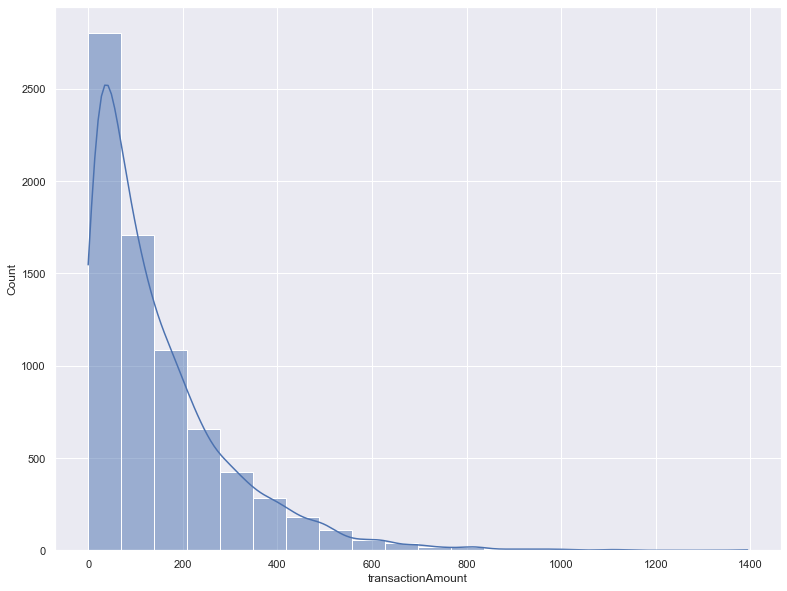

In [78]:
sns.histplot(data=df[df['not_multiswipe'] == 0],x = 'transactionAmount',bins=20,kde=True)

<AxesSubplot:xlabel='transactionAmount', ylabel='Count'>

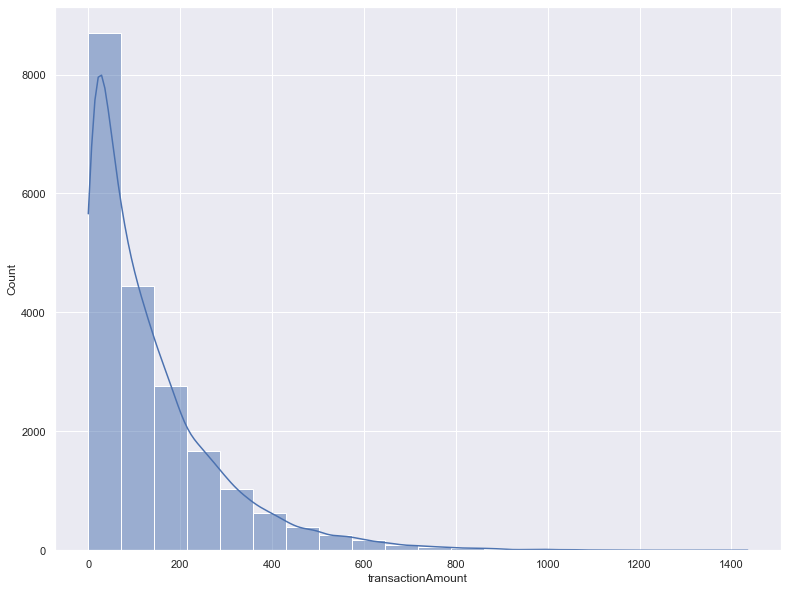

In [79]:
sns.histplot(data=df[df['transactionType'] == "REVERSAL"],x = 'transactionAmount',bins=20,kde=True)

# MODELING 

1) Lets do some more analysis so that we could start the modelling, lets do some univariate analysis and create some barplots and countplots. 

<AxesSubplot:xlabel='transactionType', ylabel='count'>

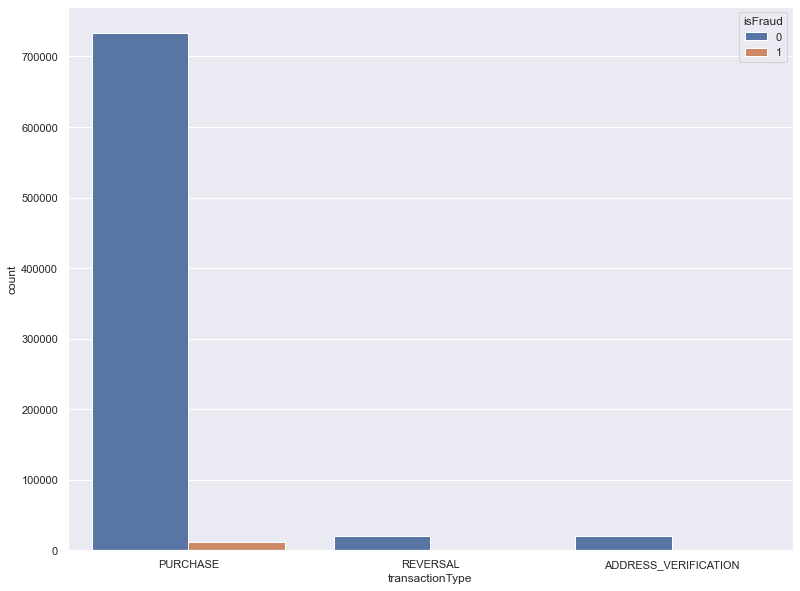

In [80]:
sns.countplot(x='transactionType',hue='isFraud',data=df)

<AxesSubplot:xlabel='count', ylabel='merchantCategoryCode'>

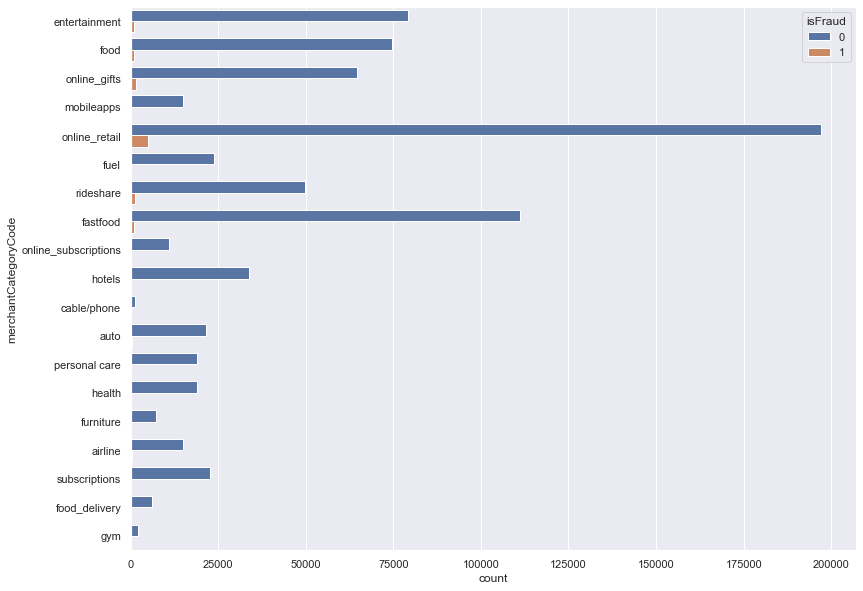

In [81]:
sns.countplot(y='merchantCategoryCode',hue='isFraud',data=df)

<AxesSubplot:xlabel='count', ylabel='trans_hr'>

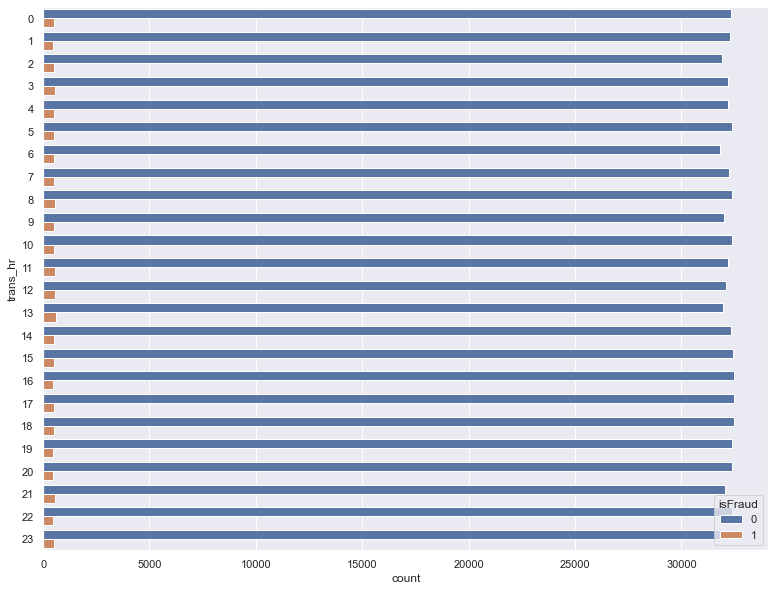

In [82]:
sns.countplot(y='trans_hr',hue='isFraud',data=df)

<AxesSubplot:xlabel='transactionType', ylabel='transactionAmount'>

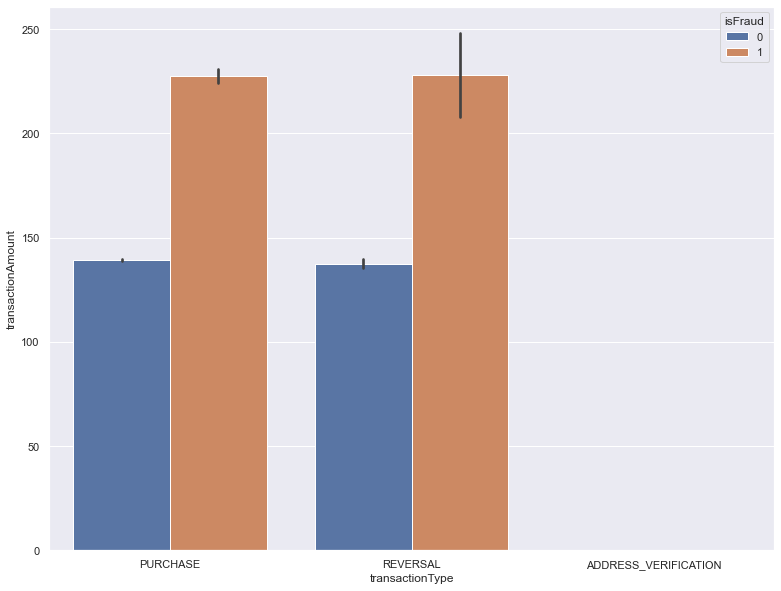

In [83]:
sns.barplot(y='transactionAmount',x='transactionType',hue='isFraud',data=df)

<AxesSubplot:xlabel='transactionType', ylabel='availableMoney'>

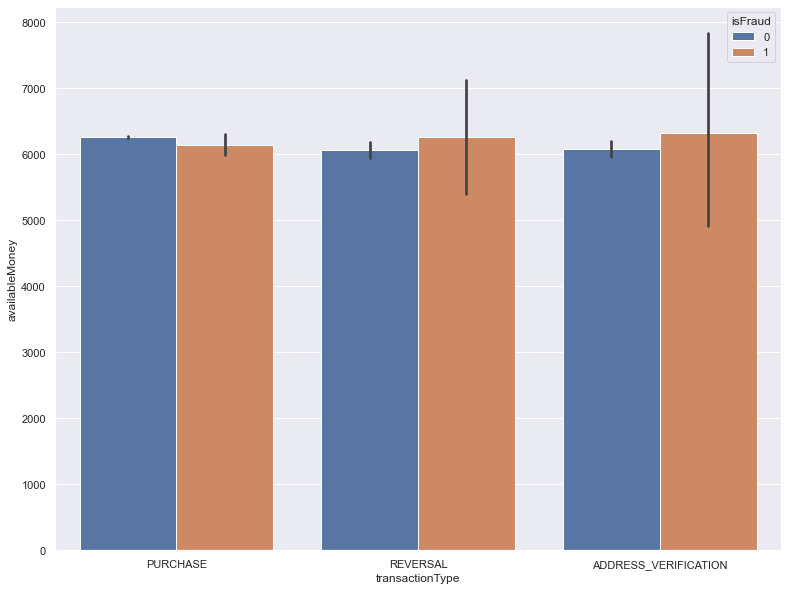

In [84]:
sns.barplot(y='availableMoney',x='transactionType',hue='isFraud',data=df)

From the above plots we can say that,

1) There seems to be a lot of fraud cases in the transactions made on online websites.

2) We see majority fraud cases in the Purchase transaction type which seems to be obvious.

3) Also the fraud cases seem to be equally distributed i.e a fraud case can be for any amount, larger or smaller, even if the customer has crossed his credit limit doesn't necessarily mean that he hasn't commited a fraud.

<b> Lets create some scatter plots to see how is the variable separation and how easily can our data identify if a case can be fraud or not </b>

1) We can see from the pair plots below that there is a really bad class separation, as seen in the scatter plots.

2) From this we can conclude the model evaluation metric such as f1-score might not be high , but depends on the case, but lets check this hypothesis this during modelling.

In [85]:
temp = df.copy()
lb = LabelEncoder()
temp['merchantName'] = lb.fit_transform(temp['merchantName'])
temp['merchantCategoryCode'] = lb.fit_transform(temp['merchantCategoryCode'])


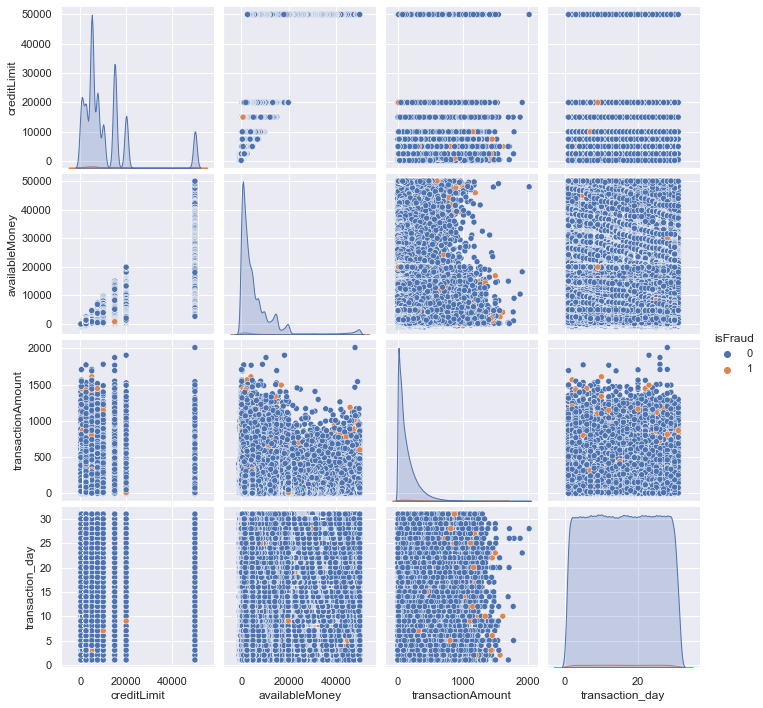

In [86]:
#In the Pair plots, the scatter plots do a bivariate analysis tell us if there is any separation.

sns.pairplot(data=df[['creditLimit','availableMoney','transactionAmount','isFraud',
                      'transaction_day']],hue='isFraud')

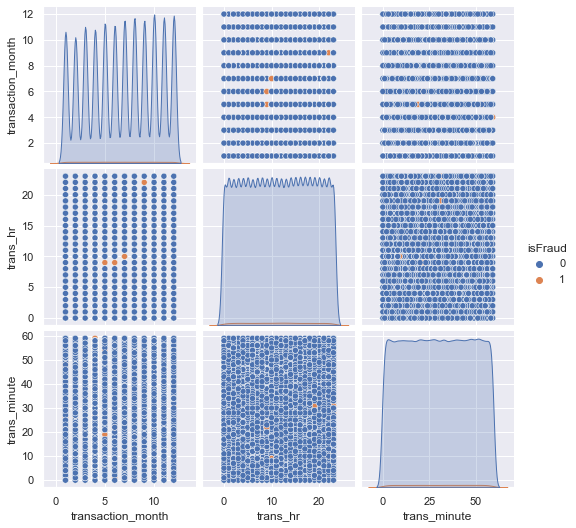

In [87]:
sns.pairplot(data = df[['transaction_month','trans_day_of_week',
                      'trans_hr','trans_minute','isFraud']],hue='isFraud')

<AxesSubplot:xlabel='merchantName'>

/Users/crazyk/opt/anaconda3/envs/test/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


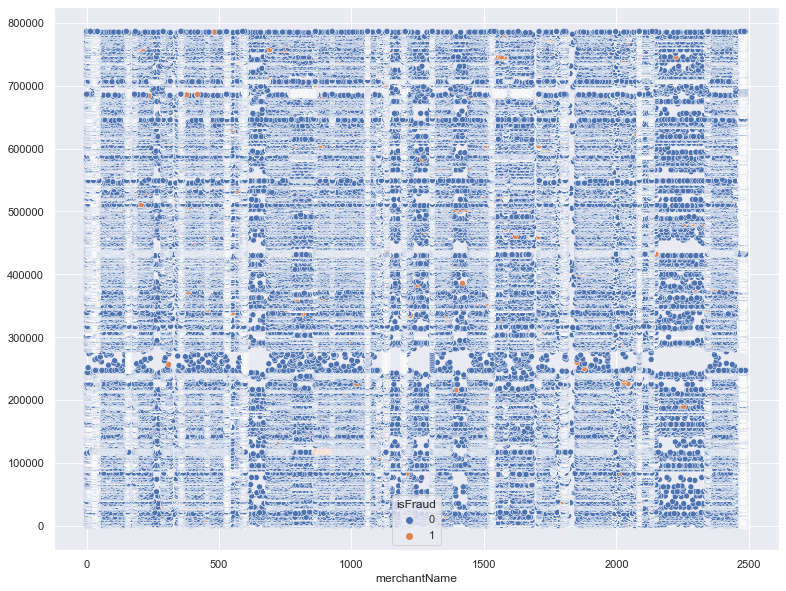

In [88]:
#Scatter plot with index as y axis 

sns.scatterplot(x='merchantName', y=range(len(temp)), data=temp, hue='isFraud', ec=None) 

<AxesSubplot:xlabel='merchantCategoryCode'>

/Users/crazyk/opt/anaconda3/envs/test/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


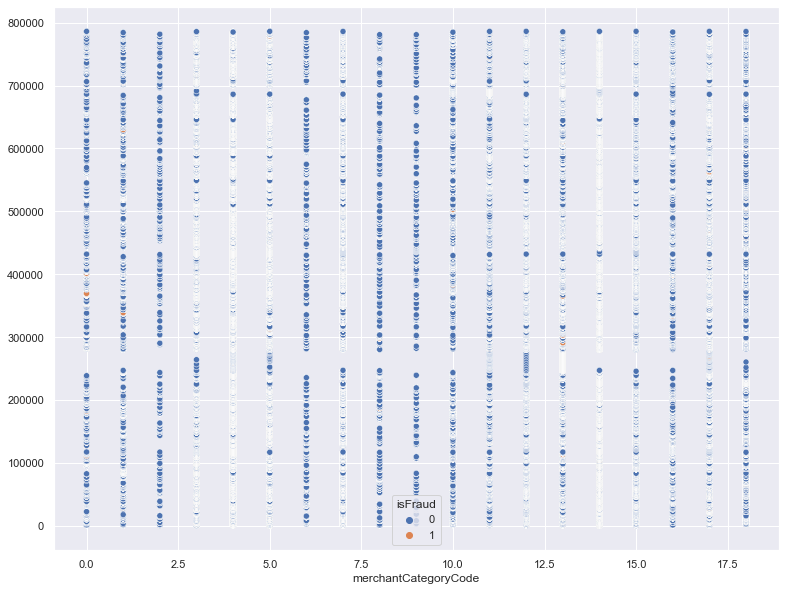

In [89]:
sns.scatterplot(x='merchantCategoryCode', y=range(len(temp)), data=temp, hue='isFraud', ec=None) 

# THE ACTUAL MODELLING

1) Since the data is highly imbalanced first we need to decide what metric we are gonna use to evaluate the model, The one i chose is the f1 score which is the harmonic mean of precision and recall. Now the reason for using f1 score is it works well on the imbalanced datasets.What I mean is if we use say, accuracy as one of the metrics our model might give us an accuracy of 95% since majority of the values are 0 which is absolutley wrong. Also in this case its highly imperative that we use f1-score because we really care about detecting fraud cases so using f1-score we will be able to do that.
Basically we need a model that can identify all of our fraud cases and at the same time only identifies fraud cases, this tradeoff between recall and precision is handled by the f1-score.
formula is  = 2*((Precision*Recall)/(Precision+Recall))

2) We will divide our dataset into test, train and also a validation to properly validate and select a perfect f1 threshold, to get a better f1-score. Really helpful and nice technique.

3) While dividing we will also make sure to use stratified sampling, i.e the distribution of fraud and not fraud cases will be the same in test,train and validation dataset.

4) We will use stratified cross validation to train the model to reduce overfitting.

5) We will also use a decision tree based model lightgbm , which uses boosting algorithm, we will also use early stopping to reduce overfitting.The reason to use lightgbm was because of how fast it is and also on the tabular data boosting algorithms seem to perform really well. We also don't need to standardize the data. Boosting algorithms also handle class imbalance really well.

6) We will use permutation feature importance to check which features contribute the most to the final predictions. 

In [90]:
#Some more feature engineering

df['Percentage_creditlimit'] = (df['transactionAmount']/df['creditLimit'])*100
df['Percentage_availmoney'] = (df['transactionAmount']/df['availableMoney'])*100

#These statistics based features help increase the average cv score
temp = df.groupby('accountNumber').agg({'Date_trans':['count'],
                                       'transactionAmount':['sum','mean','median','max','min'],
                                       'currentBalance':['sum','mean','median','max','min']})
temp.columns = ['_acc_'.join(x) for x in temp.columns]

df = pd.merge(df,temp,on='accountNumber')

"""
Converting some categorical features to one hot encoded values,its quite obvious that decision 
trees don't seem to perform well on one hot encoded values, but in my experience for 
categorical values < 30 it sometimes gives a boost to the model.
"""

df = pd.get_dummies(data=df,columns = ["acqCountry","merchantCountryCode","posEntryMode","posConditionCode","merchantCategoryCode",'transactionType'])
lb = LabelEncoder()
df['merchantName'] = lb.fit_transform(df['merchantName'])

In [91]:
"""
Dropping some features that seem a bit redundant like transactionDatetime and date since we have already used these
to create date time features so we don't need them right now also model can't process the datetime objects,
Dropping account number and customerID because these are unique to a customer and in the future we also
might get new customers so therefore these features might not let the model extrapolate properly on the 
future data.
"""
to_drop = ['accountNumber','customerId','transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange','Date_trans']
df.drop(to_drop,axis=1,inplace=True)

In [92]:
def corrleation(dataset,threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if (corr_matrix.iloc[i,j]>=threshold) and (corr_matrix.columns[j] not in col_corr):
                print(corr_matrix.columns[i],corr_matrix.columns[j])
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(colname)

In [93]:
"""
So we are checking if there are any variables with above 90% correlation with the target variable, and there seems 
to be no variable that is 90% correlated if there was we would have to remove it.
Also for the other variables that are highly correlated we can remove those features if we want it might 
help the score. The decision trees are not really affected by multicollinearity but models such as logistic regression
are.
"""
corrleation(df,0.8)

availableMoney creditLimit
availableMoney
enteredCVV cardCVV
enteredCVV
transactionAmount_acc_sum Date_trans_acc_count
transactionAmount_acc_sum
transactionAmount_acc_median transactionAmount_acc_mean
transactionAmount_acc_median
currentBalance_acc_mean currentBalance
currentBalance_acc_mean
currentBalance_acc_median currentBalance
currentBalance_acc_median
currentBalance_acc_max currentBalance
currentBalance_acc_max
merchantCountryCode_CAN acqCountry_CAN
merchantCountryCode_CAN
merchantCountryCode_MEX acqCountry_MEX
merchantCountryCode_MEX
merchantCountryCode_PR acqCountry_PR
merchantCountryCode_PR
merchantCountryCode_US acqCountry_US
merchantCountryCode_US


In [94]:
# Creating a test set

train_x,X_test,train_y,y_test = train_test_split(df,df['isFraud'],stratify=df['isFraud'],random_state=22,test_size=0.3)

In [95]:
# Creating and holdout set and train 
X_train,X_valid,y_train,y_valid = train_test_split(train_x,train_x['isFraud'],stratify=train_x['isFraud'],random_state=22,test_size=0.3)

In [96]:
X_train.drop(['isFraud','trans_day_of_week'],axis=1,inplace=True)
X_test.drop(['isFraud','trans_day_of_week'],axis=1,inplace=True)
X_valid.drop(['isFraud','trans_day_of_week'],axis=1,inplace=True)

In [97]:
# This function will be used in the early stopping we can see by verbose == True

def evaluate_F1_lgb(truth, predictions):  
    pred_labels = np.round(predictions)
    f1 = f1_score(truth, pred_labels)
    return ('F1', f1, True)

In [98]:
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=22)
final_preds = np.zeros((len(X_test), 1))
holdout_preds = np.zeros((len(X_valid),1))
oof_preds = []
final_preds_imp = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
        print("Fold {}".format(fold_))
        X_trn,y_trn = X_train.iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train.iloc[val_idx],y_train.iloc[val_idx]
        clf  = lgb.LGBMClassifier(random_state=22,n_jobs=-1,n_estimators=500,metric='custom')
        clf.fit(X_trn, y_trn, eval_metric=evaluate_F1_lgb, eval_set=[(X_val,y_val)], verbose=True,early_stopping_rounds=100)
        score = f1_score(y_pred=clf.predict(X_val),y_true=y_val)
        print(score)
        oof_preds.append(score)
        imp = importances(clf,X_val,y_val)
        imp.reset_index(inplace=True)
        final_preds_imp['Feature'] = X_val.columns
        imp.rename(columns = {'Importance':f'importances{fold_}'},inplace=True)
        final_preds_imp = pd.merge(final_preds_imp,imp,on='Feature')
        holdout_preds += clf.predict_proba(X_valid)[:,1].reshape(-1,1)
        final_preds += clf.predict_proba(X_test)[:,1].reshape(-1,1)
final_preds = final_preds/splits
houldout_preds = holdout_preds/splits
print(f"The Cross Validation score is :{sum(oof_preds)/splits}")

Fold 0
0.20886981402002863
Fold 1
0.22380612972202424
Fold 2
0.21264367816091956
Fold 3
0.23678646934460887
Fold 4
0.24084507042253522
The Cross Validation score is :0.22459023233402328


In [99]:
"""
The feature importance seem to be telling us that merchantName is the best feature and the next best is a feature 
that I created using groupby , the logic behind that was to capture user behaviours and check if in future
a certain user comes in and he has the same behaviour as the past user we can easily predict the outcome.
We can create more accountNumber based features to improve the score.

"""

final_preds_imp['Final_importance'] = final_preds_imp[final_preds_imp.columns[1:]].sum(axis=1)
final_preds_imp = final_preds_imp.sort_values(by='Final_importance',ascending=False)
final_preds_imp

,Feature,importances0,importances1,importances2,importances3,importances4,Final_importance
3,merchantName,0.0020,0.0016,0.0024,0.0030,0.0030,1.200000e-02
17,Date_trans_acc_count,0.0068,0.0002,0.0006,0.0004,0.0016,9.600000e-03
23,currentBalance_acc_sum,0.0012,0.0038,0.0006,0.0004,0.0006,6.600000e-03
25,currentBalance_acc_median,0.0018,0.0002,0.0022,0.0018,0.0002,6.200000e-03
5,enteredCVV,0.0018,0.0006,0.0008,0.0006,0.0010,4.800000e-03
4,cardCVV,0.0014,0.0008,0.0006,0.0006,0.0012,4.600000e-03
2,transactionAmount,0.0014,0.0000,0.0004,0.0012,0.0014,4.400000e-03
21,transactionAmount_acc_max,0.0000,0.0006,0.0014,0.0006,0.0010,3.600000e-03
16,Percentage_availmoney,0.0012,0.0008,0.0004,0.0002,0.0010,3.600000e-03
15,Percentage_creditlimit,0.0010,0.0006,0.0002,0.0006,0.0010,3.400000e-03


In [100]:
"""
Since we are taking the predicted probablilites of the of the fraud cases in the holdout set and the test set,
we can try and play with probabilities and play with the threshold to check which threshold will give us the best 
f1_score . We will check the threshold on the validation set not the test set.

"""
# The function below gives us 1,0 depending upon the values set to check the f1_score
def final_f1_score(data,thresh):
    preds = []
    for i in data:
        if i >= thresh:
            preds.append(1)
        else:
            preds.append(0)
    return preds

print(f"The F1 score for holdout set for 0.5 threshold is {f1_score(y_true=y_valid,y_pred=final_f1_score(holdout_preds,0.5))}")
print(f"The F1 score for Test set for 0.5 threshold is {f1_score(y_true=y_test,y_pred=final_f1_score(final_preds,0.5))}")

The F1 score for holdout set for 0.5 threshold is 0.3082070458571147
The F1 score for Test set for 0.5 threshold is 0.21835518474374258


In [101]:
best_thresh = []
for i in tqdm(range(1,100)):
    preds = final_f1_score(holdout_preds,i/100)
    best_thresh.append(f1_score(y_pred=preds,y_true=y_valid))
print(best_thresh.index(max(best_thresh))/100,max(best_thresh))



100%|███████████████████████████████████████████| 99/99 [00:20<00:00,  4.94it/s]

0.86 0.3223005968529571


In [102]:
"""
So we can see from above that how we can manipulate threshold to increase the score of our models

"""
print(f"The F1 score for Test set for 0.5 threshold is {f1_score(y_true=y_test,y_pred=final_f1_score(final_preds,0.55))}")

The F1 score for Test set for 0.5 threshold is 0.20472061657032756


# Some things that i Tried and that didn't work

1) I tried to create more statistical based features using groupby that didn't really work during modelling, features such as accountNumber paired with hour, day and month didn't improve the f1_score.

2) I also tried to mean encode the merchantName feature using expanding mean encoding since merchant name is label encoded, it doesn't really make that much sense that it is selected as a top feature. 

3) We can also see this in the f1_score of holdout set and test set above, there seems to be some data leakage from train set to validation set that's why we are getting such a high f1_score on the validation set, and if you see it closely the test set accuracy seem to be same as the cross validation score.

4) Also different models such as logistic regression, random forest was tried they didn't perform as well as a boosting model.

5) I also used different sampling technique that stratified grouped kfold, in that i tried to group account numbers in a way they are sampled using stratified sampling this didn't perform good on the dataset.



# Some things that I could have tried given more time

1) Undersampling the data and then training the model.

2) Oversampling the data using SMOTE.

3) Creating more features and also using feature selection methods such as VIF, feature importances and lofo.

4) Could have tried deep neural networks, and also tried to tune hyperparameters in addition to that could have 
tried to create an ensemble of models.

5) Getting more Domain knowledge from the internet

# Some Questions Regarding the data?

1) The data seem to be a bit poor when it comes to detecting fraud and from the data points i had , it was really impossible to find out if a transaction was fraud or not, so is there more data points available??

2) How is the data collected i.e how does the data enters into the system or queried via accountNumber or customerID?

3) Majority of the fraud transactions were online why is that the case??

4) In the problem statement a transaction if done by stealing a card,stolen credit cards on the web and via credit card skimming devices are considered fraud but there were no features that dictated that card was stolen or skimmed etc. Features such as geo location of the transaction would help a lot, in addition to that details on online websites where data breaches have happened recently would also boost the scores.

# Conclusion

1) As seen from the visualizations that there was little or no class separation to be seen , therefore our hypothesis , which was that the the metric of choice we use won't give us a very high evaluation score, and that seems to be the case when we test it with our model.

2) The model seems to have a difficulty in determining the fraud and non fraud classes, this is because of lack of 
features in my opinion.

3) With a better domain knowledge and better understanding of the features i can improve the model.